# LSTM - Random Embedding vs GloVe Embedding

We saw that in our deep learning network that model performance starts to decrease as we increase examples. One theory is that this has to do with our embedding layer - we were using random embedding originally.

In this notebook, we will comapre the results of running our samples through random embedding vs GloVe embedding (pre-trained) so we can rule out that issue might have to be with our embedding layer

## Architecture

* 16 LSTM/GRU Units - we used this so we can iterate faster as it trains the fastest
* Class weight: balanced
* All dropout has been removed from the architecture


## Notebooks

### LSTM (Random Embedding)
* 6.1.1-LSTMB16-200k-prototype.ipynb
* 6.1.2-LSTMB16-500k-prototype.ipynb
* 6.1.3-LSTMB16-1mil-prototype.ipynb


### LSTM (GloVe)
* 6.5.1-LSTMB16-GloVe-200k-prototype.ipynb
* 6.5.2-LSTMB16-GloVe-500k-prototype.ipynb
* 6.5.3-LSTMB16-GloVe-1m-prototype.ipynb
* 6.5.4-LSTMB16-GloVe-2m-prototype.ipynb

### Bidirectional GRU (GloVe)
* 7.0.0-biGRU16-GloVe-200k-prototype.ipynb
* 7.0.1-biGRU16-GloVe-500k-prototype.ipynb


# Conclusion



In [1]:
# import sibling utilities
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import importlib
from datetime import datetime

import util.dict_util as du
import util.report_util as ru
import util.plot_util as pu

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=2)




/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vinceluk/anaconda3/envs/

Load our results for random embedding with LSTM

In [2]:
REPORT_DIR = "../reports"

REPORT_LSTM_NODROP = f'{REPORT_DIR}/2020-02-dl_prototype-report.csv'

report202002 = pd.read_csv(REPORT_LSTM_NODROP, quotechar="'")
report202002 = ru.convert_dnn_report_format(report202002)
report202002["eval_metric"] = report202002.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))
report202002.train_examples = np.round(report202002.train_examples).astype(int)


report_lstm16 = report202002[report202002.model_name == "LSTMB16"]


Load our results from GloVe embedding

In [3]:
REPORT_LSTM_GLOVE = f'{REPORT_DIR}/glove_embedding-dl_prototype-report.csv'


report_glove = pd.read_csv(REPORT_LSTM_GLOVE, quotechar="'")
report_glove = ru.convert_dnn_report_format(report_glove)
report_glove["eval_metric"] = report_glove.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))
report_glove.train_examples = np.round(report_glove.train_examples).astype(int)



lstm_glove = report_glove[report_glove.model_name.str.startswith("LSTM")]
gru_glove = report_glove[report_glove.model_name.str.startswith("biGRU")]

# Model Performance - Random Embedding vs GloVe

Looks like both random embedding and GloVe have the same trends as the 2 lines are parallel

GloVe actually generally does a little bit worse than Random Embedding. I suspect that this is might be because there are words (ie, misspellings) in our review body corpus that gets removed when we use pre-trained embedding which may affect the final score for our models.

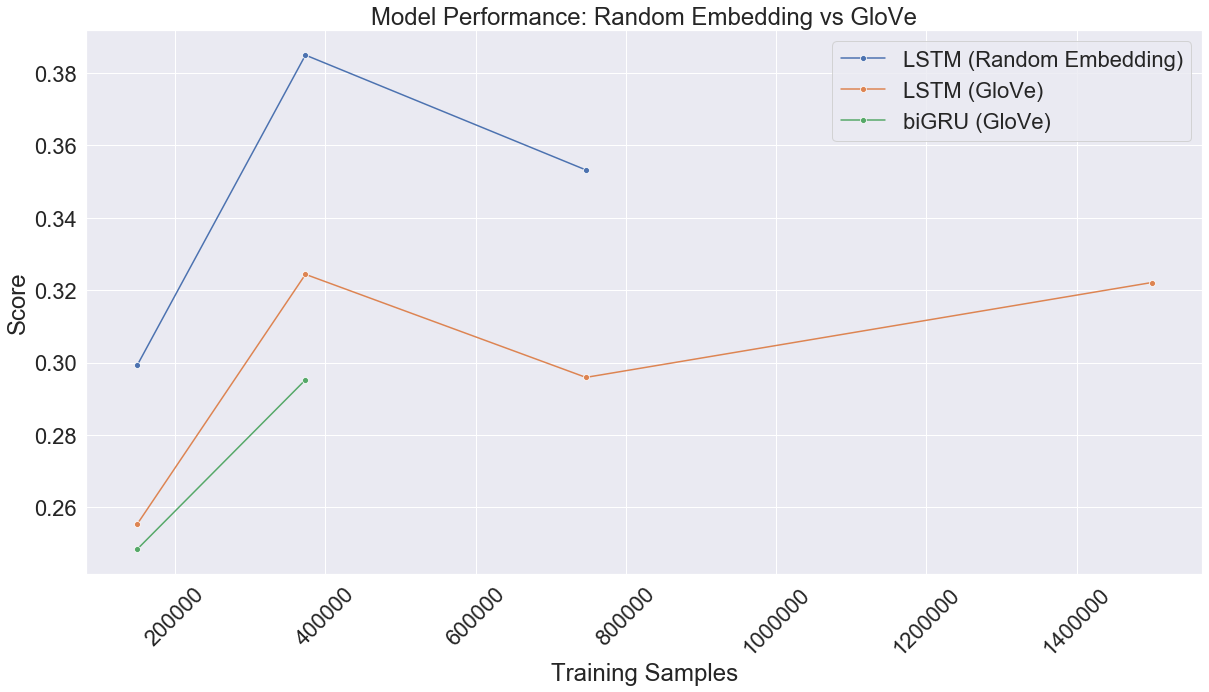

In [4]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=report_lstm16, x="train_examples", y="eval_metric", marker="o", label="LSTM (Random Embedding)")
sns.lineplot(data=lstm_glove, x="train_examples", y="eval_metric", marker="o", label="LSTM (GloVe)")
sns.lineplot(data=gru_glove, x="train_examples", y="eval_metric", marker="o", label="biGRU (GloVe)")
_ = plt.xticks(rotation=45)
_ = plt.xlabel("Training Samples")
_ = plt.ylabel("Score")
_ = plt.title("Model Performance: Random Embedding vs GloVe")




## Scores

Join the different dataframe so we can see all the scores together

In [5]:
report_all = pd.merge(
    report_lstm16[["train_examples", "eval_metric"]].rename({"eval_metric": "LSTM (Random Embedding)"}, axis=1),
    lstm_glove[["train_examples", "eval_metric"]].rename({"eval_metric": "LSTM (GloVe)"}, axis=1),
    on="train_examples",
    how="outer"
)
report_all = pd.merge(
    report_all,
    gru_glove[["train_examples", "eval_metric"]].rename({"eval_metric": "biGRU (GloVe)"}, axis=1),
    on="train_examples",
    how="outer"
)
report_all.set_index("train_examples")

,LSTM (Random Embedding),LSTM (GloVe),biGRU (GloVe)
train_examples,,,
149350,0.299256,0.255380,0.248449
373376,0.384958,0.324392,0.295249
746766,0.353228,0.295923,NaN
1500000,NaN,0.322129,NaN


# Classification Report

We are seeing similar behavior in both embedding types:
* a drop in 2-star rating recall between 500k to 1 million examples
* precision either slightly increases or stays roughly the same
* for GloVe, we are also seeing a drop in 3-star recall that we didn't see in random embedding
    * for random embedding, we see a drop in 4-star recall instead


## LSTM (Random Embedding)

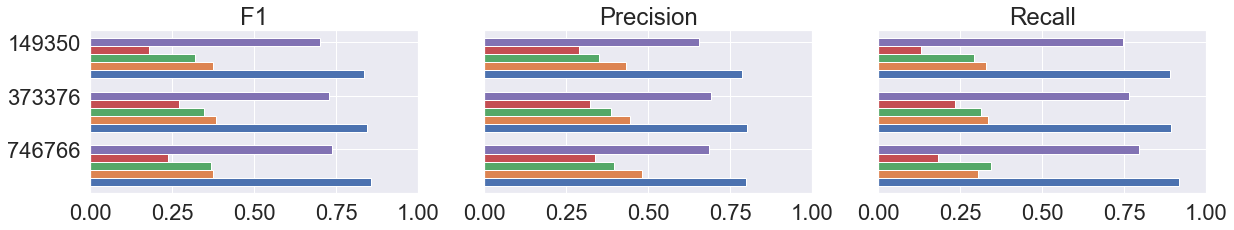

In [6]:
import util.plot_util as pu
pu.plot_score_histograms(report_lstm16, version=2, label="train_examples")

## GloVe

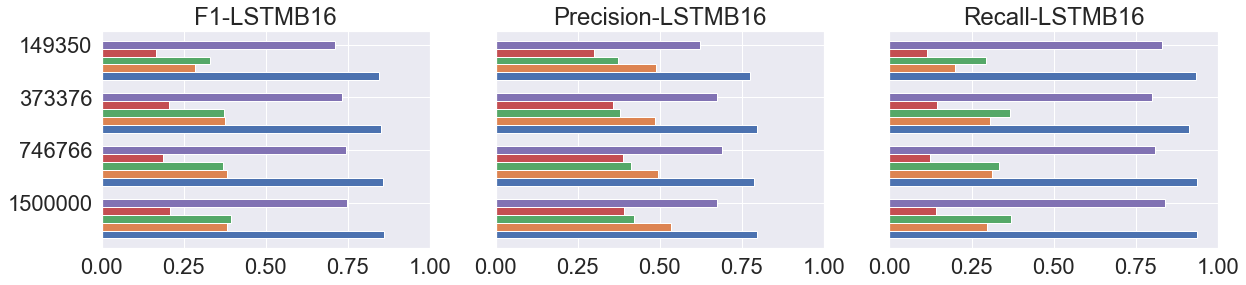

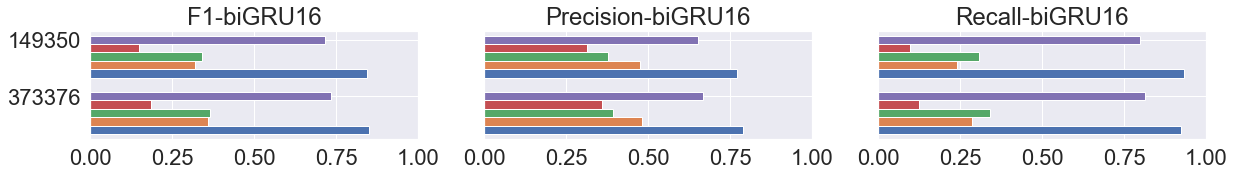

In [7]:
pu.plot_score_histograms(report_glove, version=2, label="train_examples", groupby="model_name")

In [9]:
print(datetime.now())

2020-02-08 14:27:13.946980
